In [1]:
#import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from skimage.transform import resize
import pandas as pd
import os
from tensorflow import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import layers
from keras import regularizers
from keras.utils import np_utils
from keras import callbacks
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
EPOCHS = 50


In [2]:
cd Desktop\ENEL_final_project

C:\Users\nehag\OneDrive - University of Calgary\Desktop\ENEL_final_project


In [22]:
#testfile = '\archive\asl_alphabet_test\asl_alphabet_test'
#trainfile = '\archive\asl_alphabet_test\asl_alphabet_train'
model_low = "Sequential-LowWeight.h5"
model_high = "Sequential-HighWeight.h5"
model_low1 = "Sequential-LowWeight_modified.h5"


In [23]:
import glob
from matplotlib.image import imread
path = glob.glob(r"test_data\*.jpg")
test_images =[]
for img in path:
    print(img)
    n = cv2.imread(img)
    n = cv2.resize(n, dsize=(32, 32))
    test_images.append(n)

test_data\A_test.jpg
test_data\B_test.jpg
test_data\C_test.jpg
test_data\D_test.jpg
test_data\E_test.jpg
test_data\F_test.jpg
test_data\G_test.jpg
test_data\H_test.jpg
test_data\I_test.jpg
test_data\J_test.jpg
test_data\K_test.jpg
test_data\L_test.jpg
test_data\M_test.jpg
test_data\nothing_test.jpg
test_data\N_test.jpg
test_data\O_test.jpg
test_data\P_test.jpg
test_data\Q_test.jpg
test_data\R_test.jpg
test_data\space_test.jpg
test_data\S_test.jpg
test_data\T_test.jpg
test_data\U_test.jpg
test_data\V_test.jpg
test_data\W_test.jpg
test_data\X_test.jpg
test_data\Y_test.jpg
test_data\Z_test.jpg


In [24]:
test_images

[array([[[130,  87,  96],
         [104,  87,  98],
         [ 98,  79,  82],
         ...,
         [106,  89, 103],
         [104,  84,  98],
         [121,  99, 111]],
 
        [[105,  78,  72],
         [ 79,  84,  85],
         [ 96, 102, 102],
         ...,
         [ 64,  78,  96],
         [ 66,  85, 102],
         [ 72,  95, 117]],
 
        [[251, 232, 209],
         [238, 230, 201],
         [209, 201, 187],
         ...,
         [ 44,  52,  71],
         [ 37,  41,  59],
         [ 21,  34,  52]],
 
        ...,
 
        [[ 98,  73,  66],
         [ 71,  76,  74],
         [ 72,  77,  76],
         ...,
         [109, 122, 131],
         [113, 123, 133],
         [108, 122, 137]],
 
        [[ 98,  71,  68],
         [ 73,  78,  77],
         [ 74,  81,  76],
         ...,
         [114, 127, 135],
         [115, 128, 136],
         [114, 126, 141]],
 
        [[ 96,  73,  72],
         [ 72,  82,  79],
         [ 72,  84,  76],
         ...,
         [108, 129, 138],
  

In [25]:
test_images = np.array(test_images)
test_images.shape

(28, 32, 32, 3)

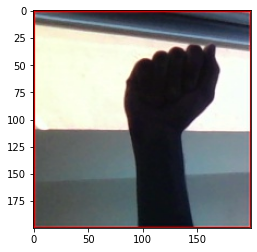


 (200, 200, 3)


In [20]:
ex = cv2.imread(r'archive\asl_alphabet_test\asl_alphabet_test\A\A_test.jpg')
plt.imshow(ex)
plt.show()
print('\n',ex.shape)

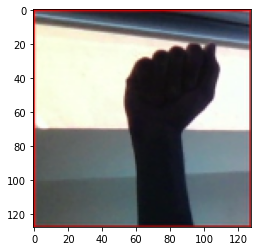


 (128, 128, 3)


In [21]:
n = cv2.resize(ex, dsize=(128, 128))
plt.imshow(n)
plt.show()
print('\n',n.shape)

In [26]:
model_low = keras.models.load_model(model_low)

model_low.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 29, 29, 16)        784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          3

In [27]:
LAYER_NAME='conv2d_2'

In [28]:

# METHOD 1 - IGNORE

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap_resized = resize(heatmap,(32, 32))
    return heatmap_resized


In [29]:
# Remove last layer's sigmoid
def grad_cam(model, layer_name):
    model.layers[-1].activation = None


    plt.figure(figsize = (6,12),dpi = 100)

    for ii in range(test_images.shape[0]):
        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(test_images[ii][np.newaxis,:,:], model, layer_name)
        plt.subplot(7,4,ii+1)
        plt.imshow(test_images[ii])
        plt.imshow(heatmap, alpha = 0.65, cmap = "inferno")
        #plt.colorbar()
        plt.axis("off")
    plt.show()
    

# LOW WEIGHT (OLD ONE)

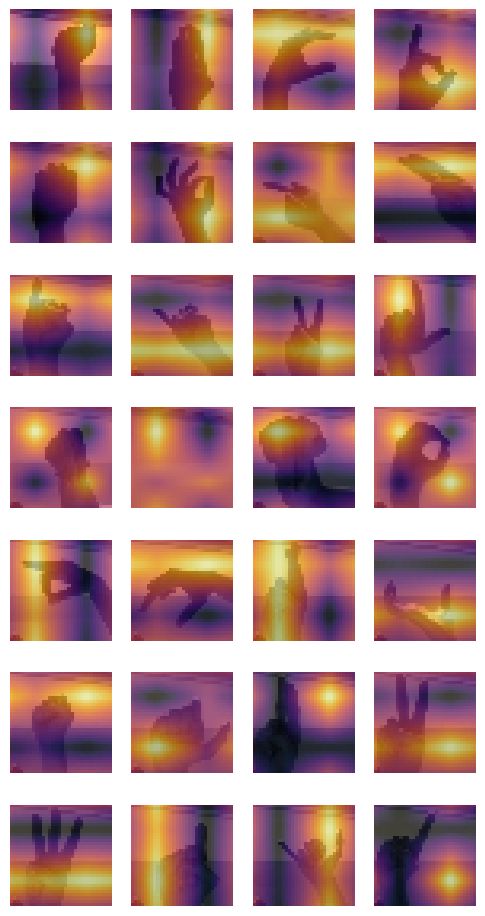

In [31]:
layer_name = 'conv2d_2'
grad_cam(model_low, layer_name)

# HIGH MODEL

In [32]:
model_high = keras.models.load_model(model_high)

model_high.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 256)        0

C:\Users\nehag\anaconda3\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\nehag\anaconda3\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


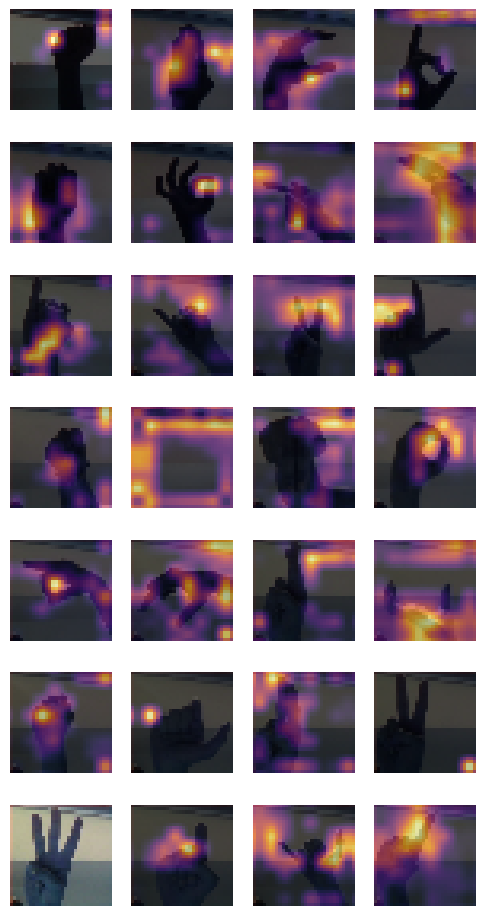

In [33]:
layer_name = 'conv2d_2'
grad_cam(model_high, layer_name)

# LOW MODEL NEW MODIFIED

In [34]:
model_low1 = keras.models.load_model(model_low1)

model_low1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

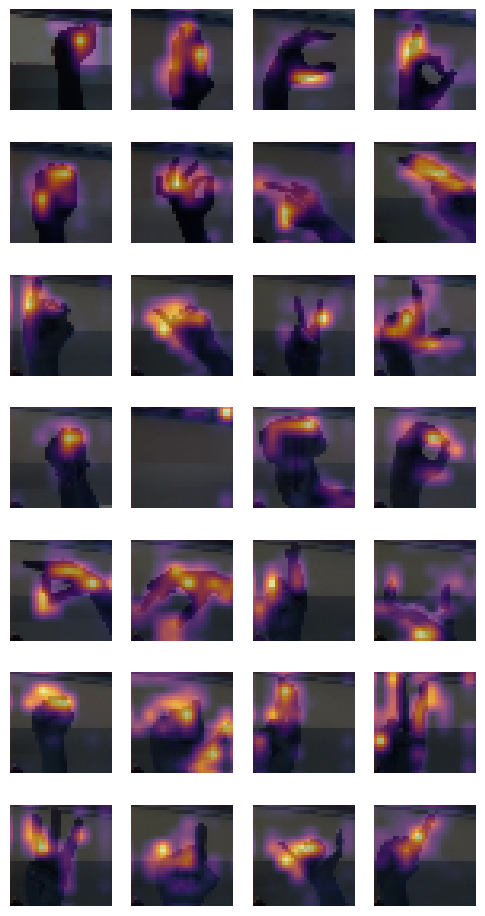

In [35]:
layer_name = 'conv2d_2'
grad_cam(model_low1, layer_name)